## MLB data analysis 1: Using the career split data

In [119]:
import pandas as pd;
import numpy as np;

from matplotlib import pyplot as plt
plt.style.use('ggplot');
import scipy.stats as stats

columns_career = ["ID", "Name", "Situation", "G", "AB", "R", "H", "2B", "3B", "HR", "RBI", "BB", "IBB", "SO", "HBP", "SH", \
                 "SF", "XI", "ROE", "GDP", "SB", "CS", "AVG", "OBP", "SLG"]; # len() = 25
columns_dtype = [str]*3 + [np.float64]*22;

columns_dtype_dict = dict(zip(columns_career, columns_dtype));

In [38]:
df_player_career_split = pd.read_csv("player_career_split_data.csv", usecols = columns_career, dtype = columns_dtype_dict);

In [97]:
AB_threshold = 30;

temp = df_player_career_split[df_player_career_split["Situation"] == "RISP"];
temp = temp[temp["AB"] >= AB_threshold];

RISP_comp = pd.merge(df_player_career_split[df_player_career_split["Situation"] == "Total"], temp, on = "ID");
# RISP_comp.loc[0] # Total: 3771, 12364, 964, 2956
#.merge(df_player_career_split[df_player_career_split["Situation"] == "RISP"], on = "ID")


# print(RISP_comp.loc[RISP_comp.shape[0]-1])
res = stats.fisher_exact([[3771-964,964], [8593-1992,1992]], alternative="greater");
res[1];

In [114]:
p_RISP = [];
for i in range(RISP_comp.shape[0]):
    temp_list = RISP_comp.loc[i, ["AB_x", "H_x", "AB_y", "H_y"]];
    res = stats.fisher_exact([[temp_list[1]-temp_list[3], temp_list[3]], \
                              [temp_list[0]-temp_list[2]-(temp_list[1]-temp_list[3]), temp_list[2]-temp_list[3]]], \
                             alternative="greater")[1];
    p_RISP.append(res);

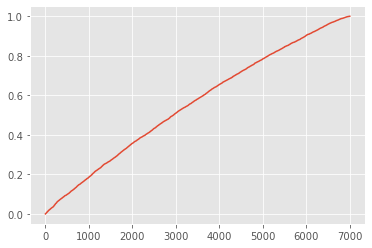

In [120]:
test = sorted(p_RISP)
plt.plot(test)

## Some statistical references

- How can we determine whether two processes produce the same proportion of defectives? From NIST
    https://www.itl.nist.gov/div898/handbook/prc/section3/prc33.htm
- Fischer's exact test (have implementation in scipy)
    https://en.wikipedia.org/wiki/Fisher's_exact_test
- Barnard's test (have documentation in scipy, but the function seemed to be removed)
    https://en.wikipedia.org/wiki/Barnard%27s_test
